# Accept–Reject Group Comparison
Compare group-level accept-minus-reject maps from beta series vs traditional models.

### Important:  I'm fully aware that I'm not properly using statistics here
I'm running models where each subject has 4 contrast estimates so the data are, technically, repeated measures and an OLS model is not appropriate.  That said, the goal here is to simply verify that the statistics maps are similar and I didn't want to generate within-subject model outputs that I don't actually need.

In [1]:
from pathlib import Path
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map
from nilearn.maskers import NiftiMasker

from dd_kable_analysis.config_loader import load_config

cfg = load_config()
output_root = Path(cfg.output_root)

beta_series_dir = output_root / 'beta_series' / 'first_level'
traditional_dir = output_root / 'traditional_model' / 'first_level'


In [2]:
def collect_maps(base_dir: Path):
    ll_minus_ss_pattern = '*contrast-ll_minus_ss_output-effectsize.nii.gz'
    return sorted(base_dir.glob(f'sub-*/contrast_estimates/{ll_minus_ss_pattern}'))


def index_maps(paths):
    index = {}
    regex = re.compile(
        r'sub-(?P<sub>[^_]+)_ses-(?P<ses>[^_]+)_task-(?P<task>[^_]+)_'
        r'run-(?P<run>[^_]+)_ll_minus_ss_output-effectsize.nii.gz'
    )
    for p in paths:
        match = regex.search(p.name)
        if not match:
            continue
        key = (match.group('sub'), match.group('run'))
        index[key] = p
    return index


In [3]:
beta_maps = collect_maps(beta_series_dir)
trad_maps = collect_maps(traditional_dir)

print(f'Num beta_maps = {len(beta_maps)}')
print(f'Num trad_maps = {len(trad_maps)}')

Num beta_maps = 439
Num trad_maps = 439


In [9]:
design_matrix = pd.DataFrame({'intercept': np.ones(len(beta_maps))})

beta_slm = SecondLevelModel(smoothing_fwhm=cfg.smoothing_fwhm)
beta_slm = beta_slm.fit(beta_maps, design_matrix=design_matrix)
beta_zmap = beta_slm.compute_contrast(
    second_level_contrast='intercept', output_type='z_score'
)

In [10]:
trad_slm = SecondLevelModel(smoothing_fwhm=cfg.smoothing_fwhm)
trad_slm = trad_slm.fit(trad_maps, design_matrix=design_matrix)
trad_zmap = trad_slm.compute_contrast(
    second_level_contrast='intercept', output_type='z_score'
)


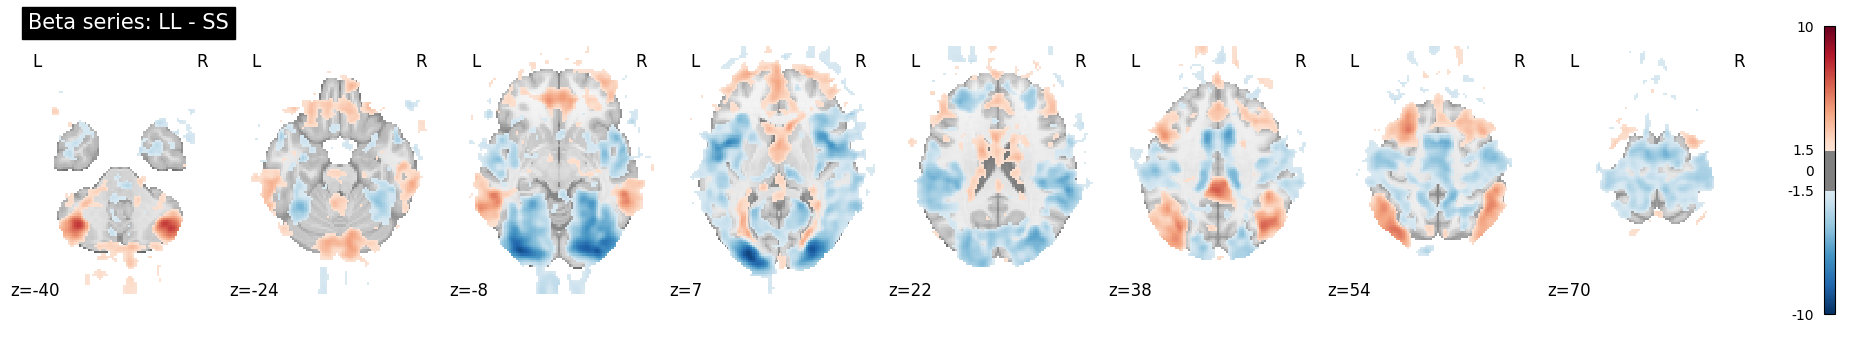

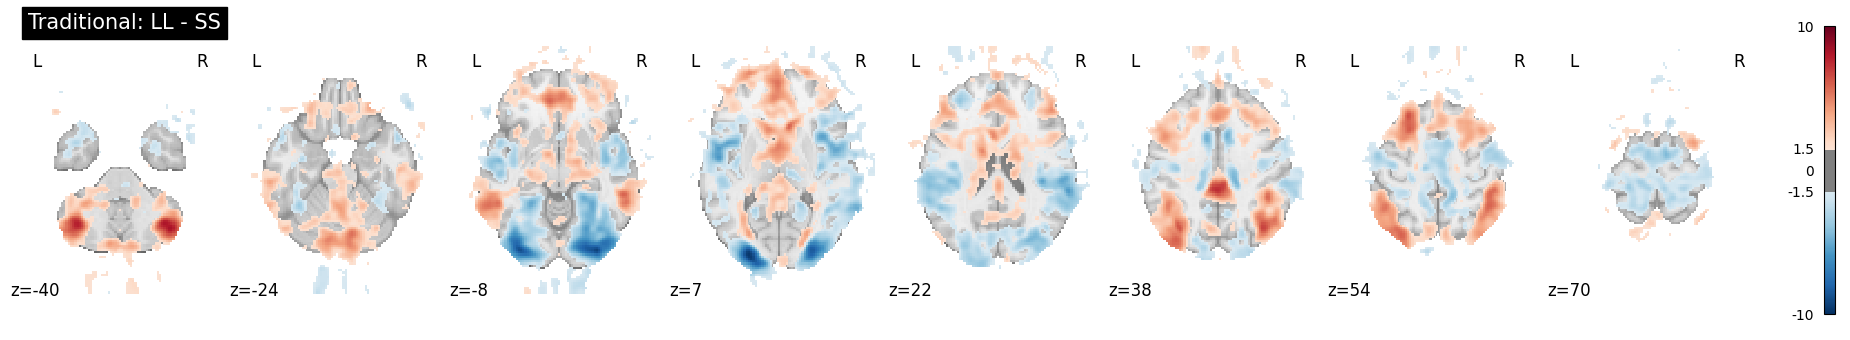

In [11]:
# Plot group z-maps with consistent z-slices
z_coords = np.linspace(-40, 70, 8)
thresh_val = 1.5

plot_stat_map(
    beta_zmap,
    display_mode='z',
    cut_coords=z_coords,
    title='Beta series: LL - SS',
    threshold=thresh_val,
)
plt.show()


plot_stat_map(
    trad_zmap,
    display_mode='z',
    cut_coords=z_coords,
    title='Traditional: LL - SS',
    threshold=thresh_val,
)
plt.show()

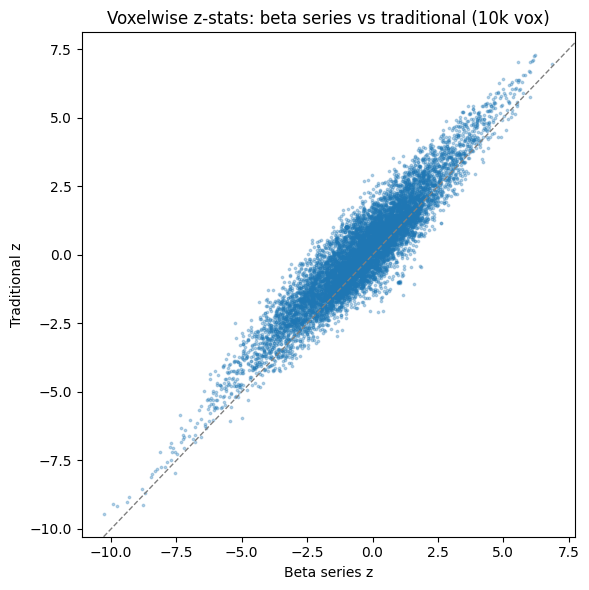

In [12]:
masker = NiftiMasker()
beta_vals = masker.fit_transform(beta_zmap).ravel()
trad_vals = masker.transform(trad_zmap).ravel()

n_vox = beta_vals.size
n_sample = min(10000, n_vox)
rng = np.random.default_rng(7)
sample_idx = rng.choice(n_vox, size=n_sample, replace=False)

plt.figure(figsize=(6, 6))
plt.scatter(beta_vals[sample_idx], trad_vals[sample_idx], s=3, alpha=0.3)
plt.xlabel('Beta series z')
plt.ylabel('Traditional z')
plt.title('Voxelwise z-stats: beta series vs traditional (10k vox)')
plt.axline((0, 0), slope=1, linestyle='--', color='gray', linewidth=1)
plt.tight_layout()